In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import  precision_score, recall_score
from sklearn.utils import shuffle

from matplotlib import pyplot as plt

import gc

In [2]:
# oversampling и undersampling для выборки
def oversampling(data, target):
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn, ignore_index=True)
    dataNoChurn = dataNoChurn.append(dataChurnRet, ignore_index=True)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:-1], dataNoChurn.iloc[:,-1]

def undersampling(data, target):
    data1 = pd.concat([data, target], axis=1, ignore_index=True)
    dataChurn = data1[target.values == 1]
    dataNoChurn = data1[target.values == -1]
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:], ignore_index=True)
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:-1], dataChurn.iloc[:,-1]

In [3]:
# кодирование категориальных признаков
def LabelEnc(data, cat_features):
    data1 = data.copy()
    data1 = data1.fillna(0)
    enc = LabelEncoder()
    for feat in cat_features:
        data1[feat] = enc.fit_transform(data.iloc[:, feat].astype(str))
    return data1

def OrdinalEnc(data, cat_features):
    data1 = data.copy()
    enc = OrdinalEncoder()
    data1[cat_features] = enc.fit_transform(data[cat_features].astype(str))
    return data1

def OneHotEnc(data, cat_features):
    enc = OneHotEncoder()
    x = enc.fit_transform(data[cat_features].astype(str))
    x = x.toarray()
    col_names = ['OneHot_feature_'+str(i+1) for i in range(x.shape[1])]
    data1 = pd.DataFrame(data=x, columns=col_names)
    data2 = pd.DataFrame(data[num_features])
    return pd.concat([data2, data1], axis=1)
#Замена каждой категории числом входящих в неё объектов
def ReplaceWithNumberObj(data, cat_features):
    data1 = data.copy()
    for feat in cat_features:
        data1[feat] = data[feat].map(data.groupby(feat).size())
    return data1
#Замена каждой категории средним значением какого-либо вещественного признака
#для объектов с тем же значением категориальной переменной
def ReplaceWithMean(data, cat_features, num_feature):
    data1 = data.copy()
    mean = data[num_feature].mean()
    for feat in cat_features:
        for val in data[feat].unique():
            data1.loc[data[feat] == val, feat]= data[num_feature][data[feat] == val].mean()
    return data1

def PRCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    n = 1
    mean_prec = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):  
        precision, recall, _ = precision_recall_curve(y_true[i].dropna(),y_probas[j].dropna())
        prec = round(average_precision_score(y_true[i].dropna(),y_probas[j].dropna()),2)
        mean_prec.append(prec)
        plt.plot(recall, precision, color='g', label='PrecisionRecall Fold '+str(n)+ f' AvgPrec = {prec}')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
        n += 1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="upper right")
    mean_prec = np.array(mean_prec)
    plt.title(f'Precision-Recall curve: Mean PR={round(mean_prec.mean(), 2)}')
    plt.show()

def ROCCurve(y_true, y_probas):
    plt.figure(figsize=(10,10))
    linewidth = 2
    n = 1
    mean_roc = []
    # для каждого фолда
    for i,j in zip(y_true, y_probas):
        fpr, tpr, thresholds = roc_curve(y_true[i].dropna(),y_probas[j].dropna())
        roc = round(auc(fpr,tpr),2)
        mean_roc.append(roc)
        plt.plot(fpr, tpr, color='g', label='ROC Fold '+str(n)+ f' Area = {roc}', lw=linewidth)
        n += 1
    plt.plot([0, 1], [0, 1], color='b', lw=linewidth, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.legend(loc="lower right")
    mean_roc = np.array(mean_roc)
    plt.title(f'ROC curve: Mean ROC={round(mean_roc.mean(), 2)}')
    plt.show()

#кросс-валидация
def KFold(estimator, data, target, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame()
    fold = 1
    f1 = []
    prec = []
    rec = []
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index])
        y_scores['Fold_' + str(fold)] = pd.Series(estimator.decision_function(data.iloc[test_index, :]))
        y_pred['Fold_' + str(fold)] = pd.Series(estimator.predict(data.iloc[test_index, :]))
        y_tests['Fold_' + str(fold)] = pd.Series(target.iloc[test_index].values.flatten())
        f1.append(f1_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        prec.append(precision_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        rec.append(recall_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        fold = fold + 1
    f1 = np.array(f1)
    prec = np.array(prec)
    rec = np.array(rec)
    print(f'mean f1_score: {f1.mean()}')
    print(f'mean precision_score: {prec.mean()}')
    print(f'mean recall_score: {rec.mean()}')
    return y_scores, y_tests

#кросс-валидация для алгоритмов, не предоставляющих decision_function
def KFoldWithoutProbs(estimator, data, target, n_folds = 5):
    scf = StratifiedKFold(n_splits = n_folds)
    y_pred = pd.DataFrame()
    fold = 1
    f1 = []
    precision = []
    recall = []
    for train_index, test_index in scf.split(data, target):
        estimator.fit(data.iloc[train_index, :], target.iloc[train_index])
        y_pred['Fold_' + str(fold)] = pd.Series(estimator.predict(data.iloc[test_index,:]))
        f1.append(f1_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        precision.append(precision_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        recall.append(recall_score(target.iloc[test_index].values, y_pred.iloc[:len(test_index), fold-1]))
        fold = fold + 1
        
    precision = np.array(precision)
    recall = np.array(recall)
    print(f'mean precision_score: {precision.mean()}')
    print(f'mean recall_score: {recall.mean()}')
    return np.array(f1).mean()

In [4]:
#загрузка данных
train = pd.read_csv('train_data.csv')
labels = pd.read_csv('train_labels.csv')

# 1 Предобработка данных.

In [5]:
#заполнение пропусков
train = train.fillna(0)
#oversampling
data, target = oversampling(train, labels)
#признаки
feats = [feat for feat in data.columns]
#категориальные признаки
cat_feats = feats[190:]
#кодирование категориальных признаков
enc_data = LabelEnc(data,cat_feats)

# 2 Обучение моделей, оценка качества на кросс-валидации.

mean f1_score: 0.7105586880703072
mean precision_score: 0.6163535942644917
mean recall_score: 0.8388128933049079


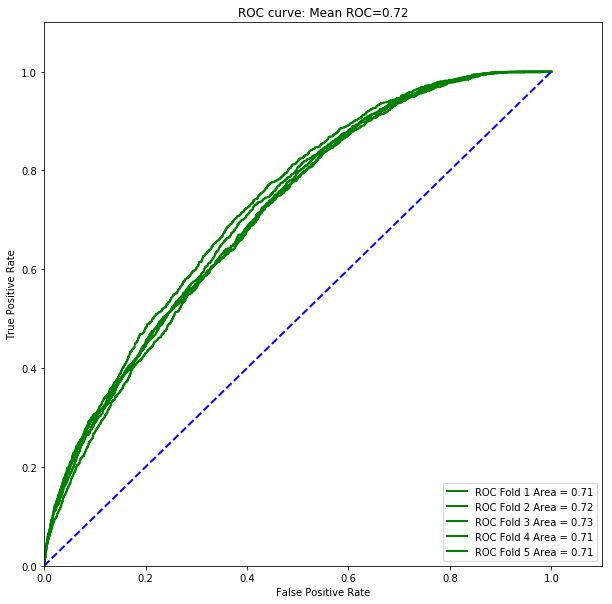

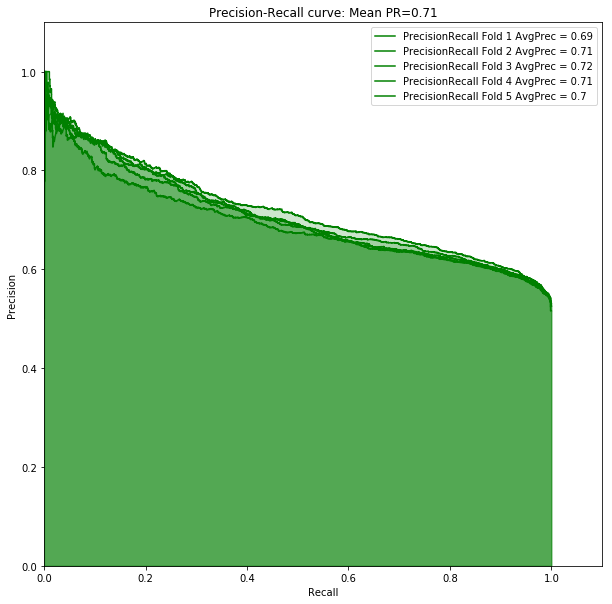

In [6]:
# градиентный бустинг:
gradBoost = GradientBoostingClassifier()
y_scores, y_tests = KFold(gradBoost, enc_data, target)
ROCCurve(y_tests, y_scores)
PRCurve(y_tests, y_scores)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.66187e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.6737e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.67056e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.66191e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.66172e-19): result may not be accurate.
  overwrite_a=True).T


mean f1_score: 0.5881490656023729
mean precision_score: 0.5440931960507598
mean recall_score: 0.6400613623054119


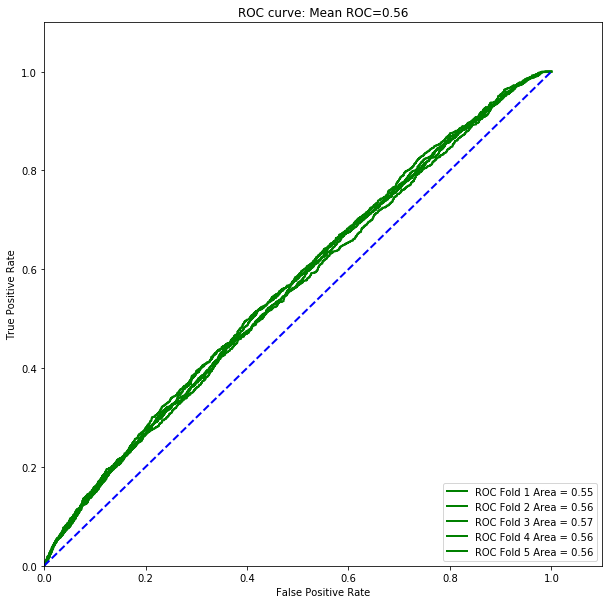

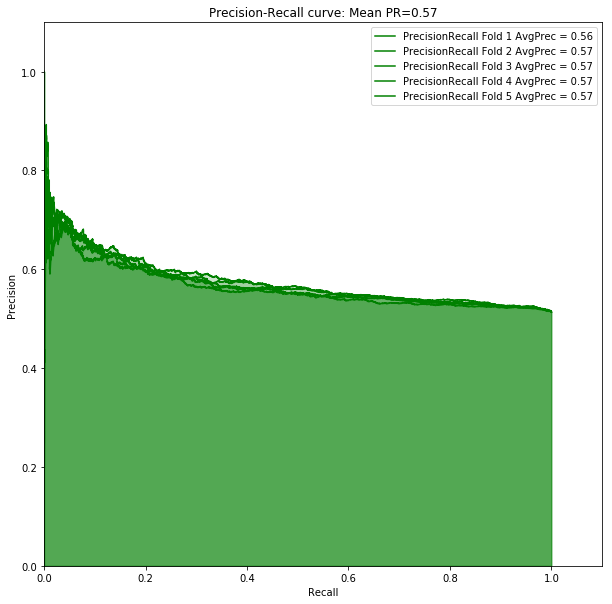

In [7]:
# Ridge:
ridge = RidgeClassifier(random_state=2)
y_scores, y_tests = KFold(ridge, enc_data, target)
ROCCurve(y_tests, y_scores)
PRCurve(y_tests, y_scores)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warni

mean f1_score: 0.5897672051353614
mean precision_score: 0.5241774941154623
mean recall_score: 0.6742492624540196


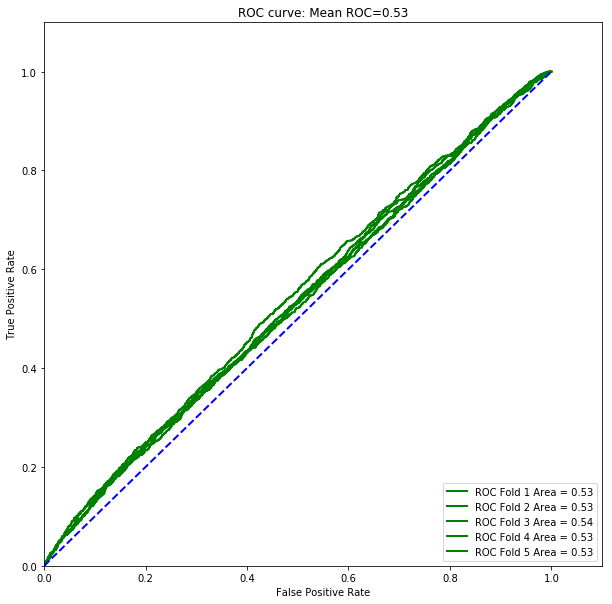

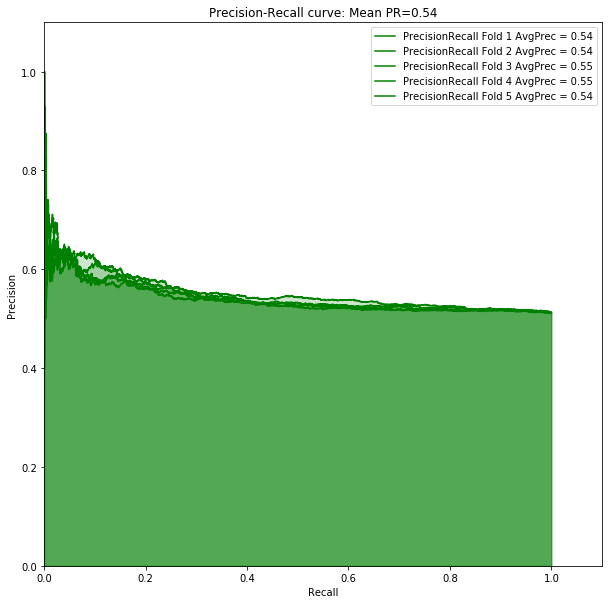

In [8]:
# LogisticRegression
logReg = LogisticRegression()
y_scores, y_tests = KFold(logReg, enc_data, target)
ROCCurve(y_tests, y_scores)
PRCurve(y_tests, y_scores)

In [9]:
#random forest
RF = RandomForestClassifier(n_estimators=100, max_depth=3)
print ('mean f1 score: '+ str(KFoldWithoutProbs(RF, enc_data, target)))

mean precision_score: 0.5270649868252633
mean recall_score: 0.9771508130552972
mean f1 score: 0.6847518107019069


C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing 

mean f1_score: 0.6763715196169953
mean precision_score: 0.5109980103325211
mean recall_score: 1.0


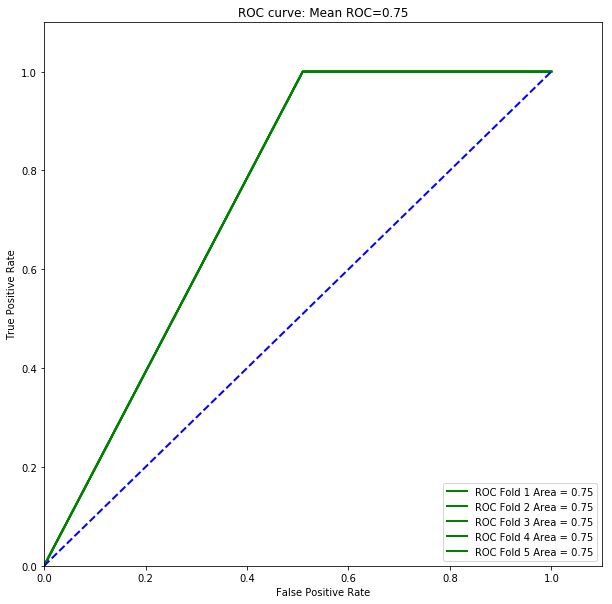

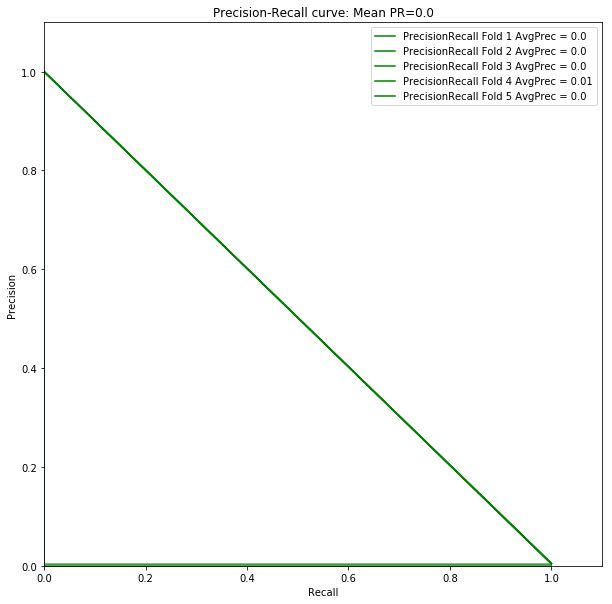

In [10]:
#SVC
clf = SVC(max_iter=10)
y_scores, y_tests = KFold(clf, enc_data, target)
ROCCurve(y_scores, y_tests)
PRCurve(y_scores, y_tests)

In [11]:
gc.collect()

5996

# 3 Выводы

Наиболее удачными алгоритмами являются градиентный бустинг и случайный лес. Возможно стоит попробовать XGBoost, подобрать параметры для случайного леса. SVM оказался нерабочим из-за требовательности к подготовке данных. Градиентный бустинг достиг AUC-ROC = 0.71 с простейшей обработкой категориальных данных LabelEncoder. Стоит попробовать более сложные методы: 

1) OneHotEncoder;

2) Замена каждой категории числом входящих в неё объектов;

3) Замена каждой категории средним значением какого-либо вещественного признака для объектов с тем же значением категориальной переменной;

4) Кодирование категориальных признаков по значениям (сочетаниям) других категориальных признаков. 

Для улучшения качества модели, сокращения затрат на ресурсы также стоит попробовать различные способы заполнения пропусков, методы отбора признаков, методы понижения размерности.